In [1]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from IPython import display

from utils import Logger

In [2]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784 # Our images have size 28x28, which is a total of 784 pixels (size of flattened vector)
        n_out = 1 # The output of the discriminator is a single number, saying how likely this is a real image (as opposed to generated)
        
        # We now declare the layers of the network. This create the variables that hold the weights (aka parameters)
        # We use the Sequential class, which itself takes a series of modules which define functions, 
        # and composes these functions, sequentially, feeding the output of one the the input of the next.
        # 
        # Linear is just a matrix multiplication plus bias vector addition
        # LeakyReLU is a variant of ReLU, which has non-zero gradient when pre-activation is negative
        # Dropout makes some neurons' activation zero ("drops them"), with a certain probability. Used as regularizer
        # 
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [3]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100 # The noise vector is of size 100 (pretty arbitrary choice!)
        n_out = 784 # The size of the output "image"
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [4]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [5]:
# Load trained model
import pickle
generator_stat_dict = pickle.load(open("trained_generator.pkl","rb"))
discriminator_stat_dict = pickle.load(open("trained_discriminator.pkl","rb"))
generator.load_state_dict(generator_stat_dict)
discriminator.load_state_dict(discriminator_stat_dict)

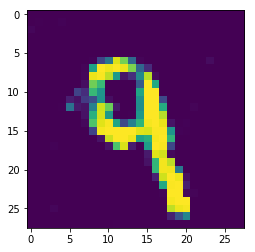

In [6]:
# vectors_to_images(generator(noise(1))).data.cpu()[0,0].numpy().shape

plt.imshow(vectors_to_images(generator(noise(1))).data.cpu()[0,0].numpy())

## Classifier

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(10 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [8]:
net = Net()
import pickle
net.load_state_dict(pickle.load(open("trained_mnist_classifier.pkl","rb")))

In [9]:
# list(net.parameters())
net.cuda()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
input = vectors_to_images(generator(noise(1)))

_,pred = torch.max(net(input),1)
pred

Variable containing:
 0
[torch.cuda.LongTensor of size (1,) (GPU 0)]

In [11]:
def plot_image(input):
    plt.imshow(input.data.cpu()[0,0].numpy())

In [12]:
net(input)

Variable containing:

Columns 0 to 7 
 14.9694  -5.2208   5.3083  -5.9013  -1.5002  -5.9714   0.6375  -3.4742

Columns 8 to 9 
  0.2685  -1.5074
[torch.cuda.FloatTensor of size (1,10) (GPU 0)]

# GANCON

In [46]:
input = Variable(torch.randn(1, 100).cuda(), requires_grad=True)
optimizer = optim.SGD([input],lr=0.001)
cost = F.cross_entropy

target_number = 4
num_iters = 2000

for ii in range(100):
    input = Variable(torch.randn(1, 100).cuda(), requires_grad=True)
    out = net(vectors_to_images(generator(input)))
    _,pred = torch.max(out,1)
    pred.data.cpu()[0]
    if pred.data.cpu()[0] == target_number:
        break

target_number = 2
for iteration in range(num_iters):
    input.grad = input_grad_zeros
    prediction = net(vectors_to_images(generator(input)))
    loss = cost(prediction,Variable(torch.LongTensor([target_number]).cuda()))
    loss.backward()
    optimizer.step()
    if iteration%(num_iters//10)==0:
        print(iteration)
        _,pred = torch.max(prediction,1)
        print("predicted: ", pred.data.cpu()[0])

0
predicted:  4
200
predicted:  4
400
predicted:  4
600
predicted:  4
800
predicted:  4
1000
predicted:  4
1200
predicted:  4
1400
predicted:  4
1600
predicted:  4
1800
predicted:  4


In [17]:
input_grad_zeros = Variable(torch.zeros(input.grad.shape).cuda())

In [ ]:
print(input.grad)

In [16]:
    prediction = net(vectors_to_images(generator(input)))
    loss = cost(prediction,Variable(torch.LongTensor([target_number]).cuda()))
    loss.backward()

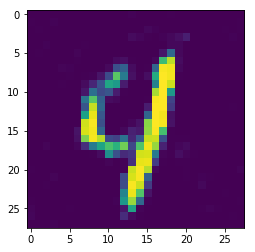

In [45]:
plot_image(vectors_to_images(generator(input)))

In [65]:
out = net(vectors_to_images(generator(input)))
_,pred = torch.max(out,1)
pred.data.cpu()[0]

7